In [111]:
import pymdp 

from pymdp import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd

In [34]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

In [44]:
#define names tumor names
tumor_names = ['t1', 't2', 't3', 't4', 't5', 't6']

#the same for resistances
resistance_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6']

#treatment names
treatment_names = ['no treatment', 'treatment']

#define the state factor array 
num_states = [len(tumor_names), len(resistance_names), len(treatment_names)]
num_factors = len(num_states)

#no possible action for tumor and resistance factor
tumor_action_names = ['Do nothing']
resistance_action_names = ['Do nothing']

#can decide to treat or not
treatment_action_names = ['dont treat', 'treat']
                      
#Define number of control states
num_controls = [len(tumor_action_names), len(resistance_action_names), len(treatment_action_names)]

#Define observation states 
tumor_observation_names = tumor_names
treatment_observation_names = treatment_names

#only tumor level is and treatment are observable, but others could be added.
num_observations = [len(tumor_observation_names), len(treatment_observation_names)]

num_modalities = len(num_observations)

## Code likelihoods

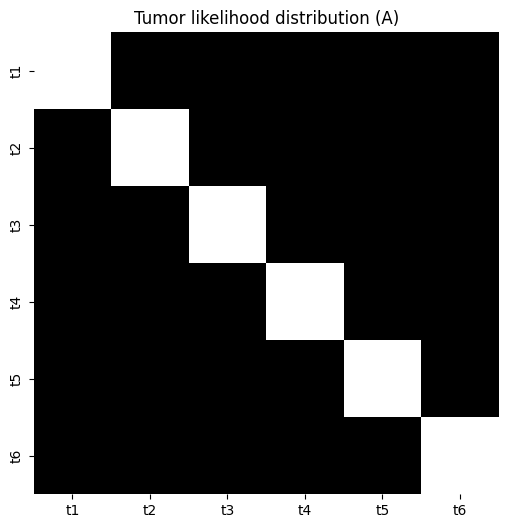

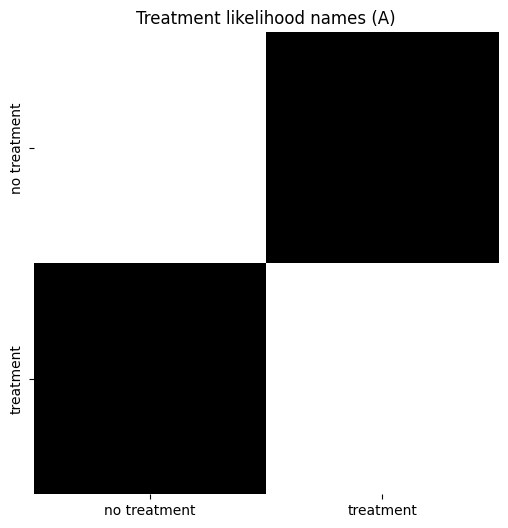

In [99]:
#Create A likelihood matrix per modality. Since there are only two observable outcomes, tumor level and treatment, there will be two likelihood arrays
#Create an empty array to store the likelihoods
A = utils.obj_array( num_modalities )

#Create a likelihood matrix for the tumor modality
A_tumor = np.zeros((len(tumor_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))
                   
#Fill in the likelihood matrix for the tumor modality, with perfect observation of the tumor level
for i in range(len(tumor_observation_names)):
    for j in range(len(tumor_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_tumor[i, j, :, :] = 1.0

#Store the likelihood matrix for the tumor modality in the likelihood array
A[0] = A_tumor

#Create a likelihood matrix for the treatment modality
A_treatment = np.zeros((len(treatment_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#Fill in the likelihood matrix for the treatment modality, with perfect observation of the treatment
for i in range(len(treatment_observation_names)):
    for j in range(len(treatment_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_treatment[i, :, :, j] = 1.0

#Store the likelihood matrix for the treatment modality in the likelihood array
A[1] = A_treatment


#Plot the likelihood matrix for the tumor modality to check. Pick the first state of the resistance factor and no treatment
plot_likelihood(A_tumor[:, :, 0, 0], xlabels = tumor_names, ylabels = tumor_observation_names, title_str = "Tumor likelihood distribution (A)")

#For treatments
plot_likelihood(A_treatment[:, 1, 2, :], xlabels = treatment_names, ylabels = treatment_observation_names, title_str = "Treatment likelihood names (A)")

In [100]:
## Code transition probabilites

In [ ]:
B = utils.obj_array(num_factors) ## stuck until enviroment is coded 







In [110]:
class DiscreteTumorEnv():

    #initialize the class, to set startint state to tuple (0,0)
    def __init__(self, tumor_starting_state = 0, resistance_starting_state = 0, treatment_starting_state = 0, tumor_increase_prob = 0.3, resistance_increase_prob = 0.5, treatment_effect_probs = [1, .8, .6, .4, .2], resistance_decrease_probs = [.0, .2, .7, .8, .9]):
        
        #simulation parameters
        self.tumor_increase_prob = tumor_increase_prob
        self.resistance_increase_prob = resistance_increase_prob
        self.treatment_effect_probs = treatment_effect_probs
        self.resistance_decrease_prob = resistance_decrease_probs

        #set the starting state for each factor
        self.init_tumor_state = tumor_starting_state
        self.init_resistance_state = resistance_starting_state
        self.init_treatment_state = treatment_starting_state

        #set the current state to the starting state
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        print(f'Starting tumor state is {tumor_starting_state}, starting resistance state is {resistance_starting_state}, starting treatment state is {treatment_starting_state}')

    #Define funciton update enviroment
    def step(self, action_label):

        #check if tumor progresses with probability set in the simulation parameters
        self.current_tumor_state = self.current_tumor_state + np.random.binomial(1, p = self.tumor_increase_prob)

        #### BREAK IF TUMOR state is 6

        #if treatment is on, check if tumor is treated and whether resistance progresses. 
        if action_label == "Treat":
            
            #if tumor is more than 1, reduce it by the treatment effect probability
            if self.current_tumor_state > 0:
                self.current_tumor_state = self.current_tumor_state - np.random.binomial(1, p = self.treatment_effect_probs[self.current_resistance_state])

            #if resistance is more than 0 and less than length of resistance states, increase it by the resistance increase probability
            if  self.current_resistance_state < len(self.resistance_decrease_prob) - 1:
                self.current_resistance_state = self.current_resistance_state + np.random.binomial(1, p = self.resistance_increase_prob)

        #if treatment is off and resistance state is more than 0, check if resistance decreases
        elif self.current_resistance_state > 0:
            self.current_resistance_state = self.current_resistance_state - np.random.binomial(1, p = self.resistance_decrease_prob[self.current_tumor_state])

        print(f'Resistance state is {self.current_resistance_state}')
        print(f'Tumor state is {self.current_tumor_state}')

        return self.current_tumor_state, self.current_resistance_state
    
    def reset(self):
        #reset states to initial states
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #print that the states have been reset
        print(f'Starting tumor state is {self.current_tumor_state}, starting resistance state is {self.current_resistance_state}, starting treatment state is {self.current_treatment_state}')

env = DiscreteTumorEnv()

Starting tumor state is 0, starting resistance state is 0, starting treatment state is 0
Resistance state is 1
Tumor state is 0
Resistance state is 1
Tumor state is 0
Resistance state is 2
Tumor state is 0
Resistance state is 2
Tumor state is 0
Resistance state is 2
Tumor state is 1
Resistance state is 3
Tumor state is 1
Resistance state is 4
Tumor state is 1
Resistance state is 4
Tumor state is 2
Resistance state is 4
Tumor state is 2
Resistance state is 4
Tumor state is 3
Resistance state is 4
Tumor state is 3
Resistance state is 4
Tumor state is 3
Resistance state is 4
Tumor state is 3
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 5
Resistance state is 4
Tumor state is 5
Resistance state is 4
Tumor state is 5
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 4
Resistance state is 4
Tumor state is 4
Resistance sta

In [115]:
#create an empty pandas dataframe to store data in 
data = pd.DataFrame(columns = ['tumor_state', 'resistance_state', 'treatment_state'])

## Simulation Loop 
for i in range(100):
    
    tumor_state, resistance_state = env.step("Treat")
    if tumor_state == 6:
        break

    #append the states to the dataframe
    data.append({'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': 'Treat'}, ignore_index = True)


Resistance state is 4
Tumor state is 3


AttributeError: 'DataFrame' object has no attribute 'append'